In [177]:
import pandas as pd
import seaborn as sns
import gensim
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

In [9]:
df = pd.read_csv('data/tokenized/in_domain_train.tsv', sep='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [11]:
df.head()

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"our friends wo n't buy this analysis , let alo..."
1,gj04,1,NaN,one more pseudo generalization and i 'm giving...
2,gj04,1,NaN,one more pseudo generalization or i 'm giving ...
3,gj04,1,NaN,"the more we study verbs , the crazier they get ."
4,gj04,1,NaN,day by day the facts are getting murkier .


# Train custom word emebeddings

In [142]:
model = gensim.models.Word2Vec(
     min_count=20,
     window=2,
     size=300,
     sample=6e-5, 
     alpha=0.03, 
     min_alpha=0.0007, 
     negative=20,
     workers=8-1
)

In [144]:
sentences = df['sentence'].apply(lambda x: x.split(' ')).values
model.build_vocab(sentences, progress_per=10000)

In [147]:
model.train(sentences, total_examples=model.corpus_count, epochs=30, report_delay=1)

(259872, 2278170)

In [148]:
model.init_sims(replace=True)

/home/superceed1/anaconda3/envs/scrapper/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


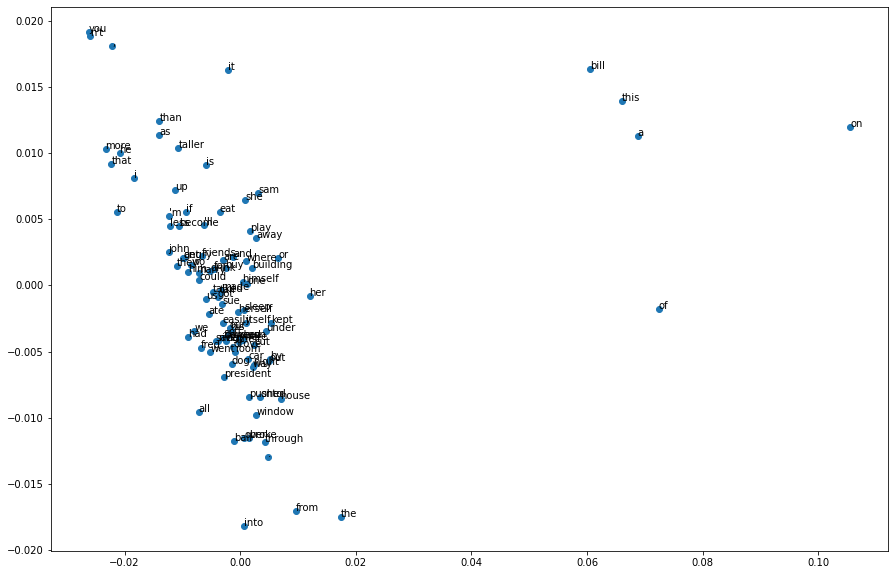

In [163]:
plt.figure(figsize=(15, 10))
words = list(model.wv.vocab)[:100]

X = model[words]
pca = PCA(n_components=2, random_state=10)
result = pca.fit_transform(X)

plt.scatter(result[:, 0], result[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

# Load custom embeddings

In [171]:
# Lets get the top 5 common words in the cola dataset
vec = CountVectorizer(stop_words='english').fit(df['sentence'].values)
cv = vec.transform(df['sentence'].values)
sum_words = cv.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
top_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
freq_df = pd.DataFrame(top_freq)

In [172]:
model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)

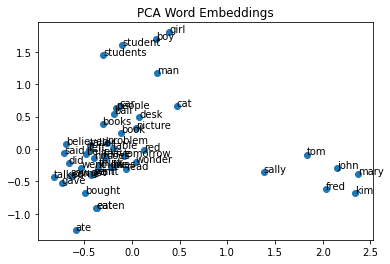

In [173]:
pca = PCA(n_components=2, random_state=0)
pca_results = pca.fit_transform(model[freq_df[:50][0]])

plt.title('PCA Word Embeddings')
plt.scatter(pca_results[:, 0], pca_results[:, 1])
words = freq_df[:50][0]
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_results[i, 0], pca_results[i, 1]))

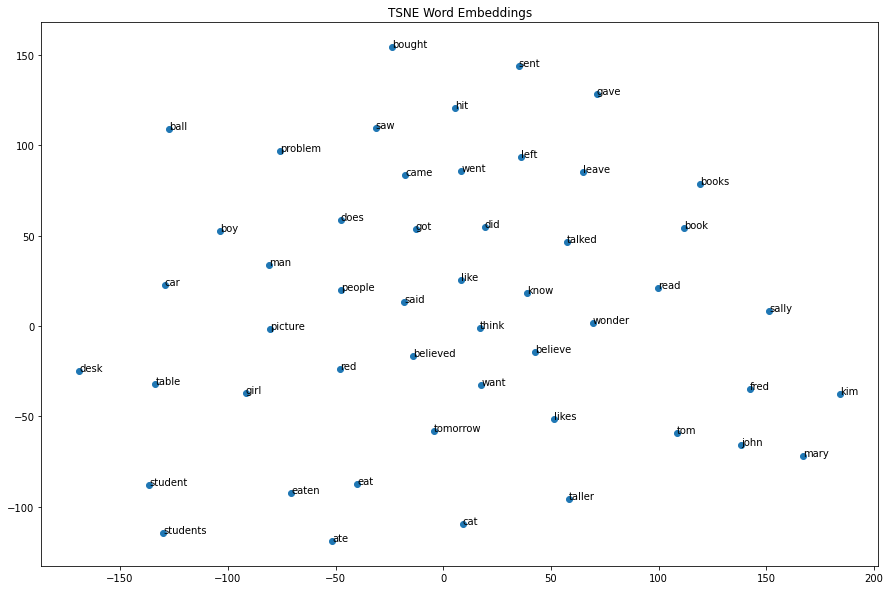

In [174]:
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(model[freq_df[:50][0]])

plt.figure(figsize=(15, 10))

plt.title('TSNE Word Embeddings')
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
words = freq_df[:50][0]
for i, word in enumerate(words):
    plt.annotate(word, xy=(tsne_results[i, 0], tsne_results[i, 1]))

# Embeddings Cluster

In [223]:
embeddings_cluster = []
word_clusters = []
topics = ['python', 'word', 'malaysia', 'school', 'learning']
for topic in topics:
    embeddings = []
    words = []
    
    for index, (similar, _) in enumerate(model.most_similar(topic, topn=20)):
        if index == 0:
            embeddings.append(model[topic])
            words.append(topic)
            
        embeddings.append(model[similar])
        words.append(similar)
        
    embeddings_cluster.append(embeddings)
    word_clusters.append(words)

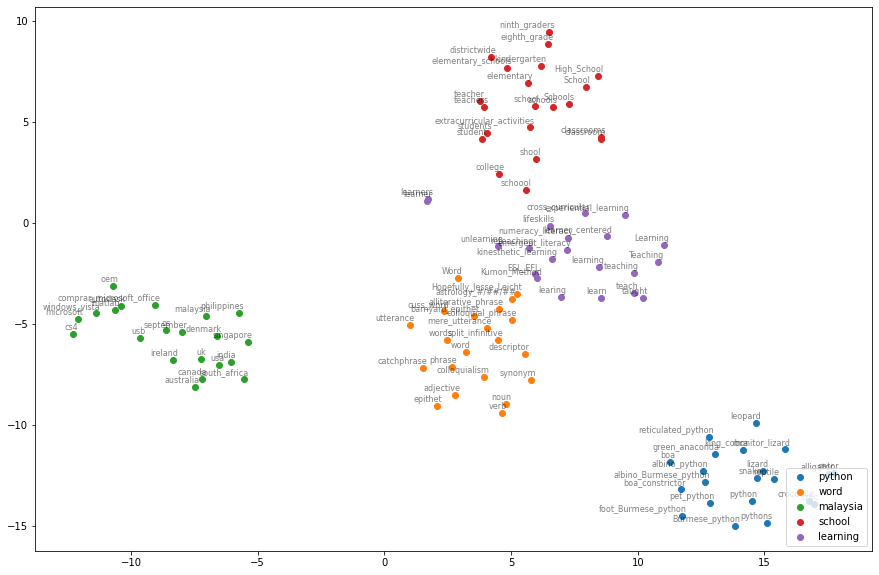

In [224]:
embedding_clusters = np.array(embeddings_cluster)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

plt.figure(figsize=(15, 10))
for topic, embedding, words in zip(topics, embeddings_en_2d, word_clusters):
    plt.scatter(embedding[:, 0], embedding[:, 1], label=topic)
    
    plt.legend(loc=4)
    for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(embedding[:, 0][i], embedding[:, 1][i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)

# Visualize 3D

In [225]:
from mpl_toolkits.mplot3d import Axes3D

In [242]:
embeddings_wp = []
for word in list(model.wv.vocab)[:5000]:
    embeddings_wp.append(model.wv[word])

/home/superceed1/anaconda3/envs/scrapper/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/home/superceed1/anaconda3/envs/scrapper/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


/home/superceed1/anaconda3/envs/scrapper/lib/python3.7/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


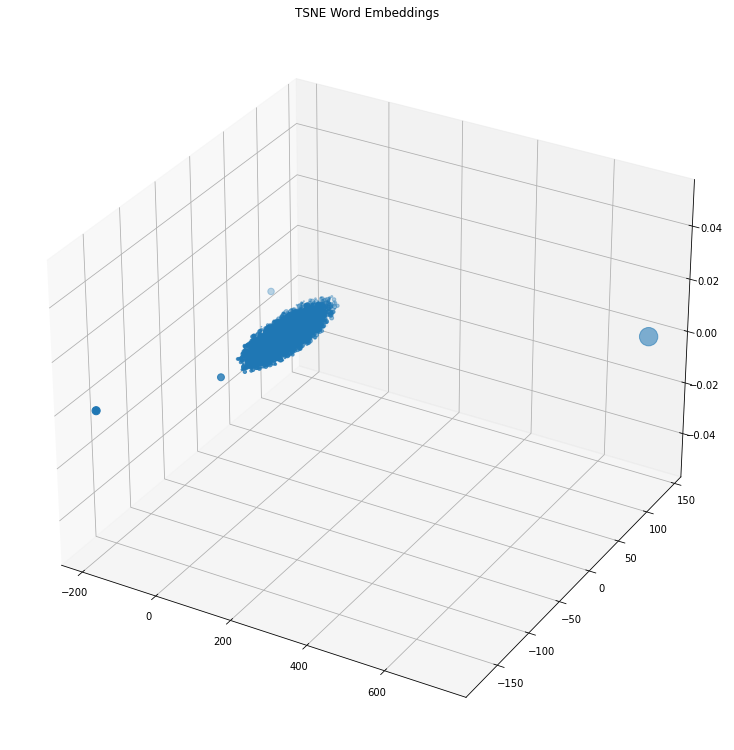

In [243]:
tsne = TSNE(n_components=3, perplexity=30, random_state=0)
tsne_results = tsne.fit_transform(embeddings_wp)

fig = plt.figure(figsize=(15, 10))
ax = Axes3D(fig)
plt.title('TSNE Word Embeddings')
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2])